In [1]:
#import sys
!{sys.executable} -m pip install tensorflow
!{sys.executable} -m pip install scikit-learn
!{sys.executable} -m pip install opencv-python
!{sys.executable} -m pip install albumentations

zsh:1: parse error near `-m'
zsh:1: parse error near `-m'
zsh:1: parse error near `-m'
zsh:1: parse error near `-m'


Importing Required Libraries

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications
import numpy as np
from sklearn.model_selection import train_test_split
import os
import cv2
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import albumentations as A
from albumentations import (
    Compose, RandomRotate90, VerticalFlip, Transpose,
    OneOf, GaussNoise, RandomBrightnessContrast,ToGray
)
import numpy as np
from sklearn.utils import resample
from PIL import Image
from tqdm import tqdm
import shutil


/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Importing Data from 'Train' folder 

In [3]:

def importData(data_dir):
    # Importing data from the 'Train' Folder
    data = data_dir
    # Creating empty list to store filenames
    files = []
    # Iterating through the data and storing the filenames in the files list
    for _, _, files in os.walk(data):
        break
    # Printing the total number of images currently being used to train and test the models below
    print(f'Total number of files: {len(files)}')
    return files

In [4]:
files = importData(data_dir='Train')

Total number of files: 971


In [5]:
#Bootstrap function : Perform bootstrapping on a list of images and return the new bootstrap list

def load_and_preprocess_image(image_path, target_size=(256, 256)):
    """Load and preprocess a single image."""
    try:
        if isinstance(image_path, list):
            image_path = image_path[0]
        
        img = cv2.imread(str(image_path))
        if img is None:
            raise ValueError(f"Failed to load image: {image_path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, target_size)
        return img
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

def bootstrap(imageList, n_samples):
    result = [np.random.choice(imageList) for _ in range(n_samples)]
    return result

def save_augmented_images(augmented_images, original_paths, output_dir):
    """Save augmented images to a new directory."""
    # Create output directory if it doesn't exist
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs('train2')
    print(f"\nSaving augmented images to {output_dir}...")

    # Create list of paths repeated 3 times for the augmented versions
    repeated_paths = []
    for path in original_paths:
        repeated_paths.extend([path] * 3)
    
    for idx, (img, orig_path) in enumerate(zip(augmented_images, repeated_paths)):
        try:
            # Get original filename and label
            orig_filename = os.path.basename(orig_path)
            label = orig_filename.split('.')[0]
            
            # Create new filename
            aug_type = idx % 3  # 0 for original, 1 and 2 for augmented versions
            new_filename = f"aug{aug_type}_{idx}_{label}.jpg"
            save_path = os.path.join(output_dir, new_filename)
            
            # Convert from RGB to BGR for saving with cv2
            img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            
            # Save image
            cv2.imwrite(save_path, img_bgr)
            
        except Exception as e:
            print(f"Error saving augmented image {idx}: {e}")
            continue

def bootstrap_and_augment(image_list, n_samples, data_dir='Train'):
    
    # Perform bootstrapping
    print("Performing bootstrapping...")
    full_paths = [os.path.join(data_dir, img) for img in image_list]
    bootstrapped_paths = np.random.choice(full_paths, size=n_samples, replace=True)

    # 3. Define transforms
    transforms = Compose([
        RandomRotate90(p=0.2),
        VerticalFlip(p=0.2),
        ToGray(p=0.2)
    ])

    # 4. Augment
    print("Loading and augmenting images...")
    augmented_images = []
    augmented_labels = []

    for img_path in tqdm(bootstrapped_paths):
        try:
            # Get label from filename
            img_filename = os.path.basename(img_path)
            label = img_filename.split('.')[0]

            # Load and preprocess image
            img = load_and_preprocess_image(img_path)
            
            # Add original image
            augmented_images.append(img)
            augmented_labels.append(label)
            
            # Create 2 augmented versions
            for _ in range(2):
                augmented = transforms(image=img)['image']
                augmented_images.append(augmented)
                augmented_labels.append('aug_'+label)
                
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            continue
    
    augmented_images = np.array(augmented_images)
    augmented_labels = np.array(augmented_labels)

    # Print summary
    print("\nSummary:")
    print(f"Original bootstrap samples: {n_samples}")
    print(f"Total augmented images: {len(augmented_images)}")
    print(f"Augmented image shape: {augmented_images.shape}")

    # Save augmented images
    save_augmented_images(augmented_images, bootstrapped_paths, 'Train2')

    return augmented_images, augmented_labels

In [6]:
# Deleting Train2 folder if exist
if os.path.exists('Train2'):
    shutil.rmtree('Train2')
# Perform bootstrapping and augmentation
X_augmented, y_augmented = bootstrap_and_augment(
    image_list=files,
    data_dir='Train',
    n_samples=1200
)

files_augmented = importData(data_dir='Train2')

print("\nfiles:", files[:5])
print("\nfiles_augmented:", files_augmented[:5])

Performing bootstrapping...
Loading and augmenting images...


100%|██████████| 1200/1200 [00:02<00:00, 522.90it/s]



Summary:
Original bootstrap samples: 1200
Total augmented images: 3600
Augmented image shape: (3600, 256, 256, 3)

Saving augmented images to Train2...
Total number of files: 3600

files: ['img872_lower.jpg', 'img569_lower.jpg', 'img45_hispanic_latino_lower.jpg', 'img1765_middle.png', 'img1398_lower.jpg']

files_augmented: ['aug1_3166_img316_middle.jpg', 'aug0_2166_img1709_upper.jpg', 'aug0_2490_img1529_middle.jpg', 'aug0_612_img1803_upper.jpg', 'aug1_2893_img967_lower.jpg']


# Image Label Classification
Classifying the images based on the labels in the filename

Something to note, I originally created the array of just size 1 that stored the value of each label in that single spot as 0,1,2 but it resulted in accuracy ratings never changing between epochs and being lower after trying different techniques this is the current attempt that is having the best results, currently values are stored in a numpy array of size 3 where the first value being 1 represents a lower class, the second being 1 represents middle and the third being 1 represents upper class.

What Y looks like
Y = ([[1. 0. 0.], [0. 1. 0.], [0. 0. 1.]])

In [7]:

def image_label_classification( files, data_dir):
    # Creating a numpy array of zeros the length of the dataset with a size of shape of 3
    Y = np.zeros((len(files), 3))

    # Loop through the list of filenames
    for i, f in tqdm(enumerate(files)):

        # If the filename contains 'lower' set the first value of the array to 1
        if 'lower' in f:
            Y[i, 0] = 1  
        # If the filename contains 'middle' set the second value of the array to 1
        elif 'middle' in f:
            Y[i, 1] = 1  
        # If the filename contains 'upper' set the third value of the array to 1
        elif 'upper' in f:
            Y[i, 2] = 1  

    #Create the path to each file 
    files = [os.path.join(data_dir, f) for f in files]

    #Example showing the path to the file and the coorisponding label showing what we have classified as middle in the numpy array.
    print(f'File location: {files[1]}\n Classified as: {Y[1]}')
    # Printing the total number of images currently being used to train and test the models below
    print(f'Total number of files: {len(files)}')
    print(f'Total number of Y: {len(Y)}')
    print('\n')
    return files,Y

In [8]:
#Raw image files and Calling the image_label_classification funciton to classify the images based on the labels in the filename
files_labeled, Y = image_label_classification(files, r'Train')
print(files_labeled[:5])
#3000 bootstrap and augmented image files and Calling the image_label_classification funciton to classify the images based on the labels in the filename
files_augmented_labeled, Y2 = image_label_classification(files_augmented, r'train2')
print(files_augmented_labeled[:5])

971it [00:00, 2211003.90it/s]


File location: Train/img569_lower.jpg
 Classified as: [1. 0. 0.]
Total number of files: 971
Total number of Y: 971


['Train/img872_lower.jpg', 'Train/img569_lower.jpg', 'Train/img45_hispanic_latino_lower.jpg', 'Train/img1765_middle.png', 'Train/img1398_lower.jpg']


3600it [00:00, 4030831.39it/s]

File location: train2/aug0_2166_img1709_upper.jpg
 Classified as: [0. 0. 1.]
Total number of files: 3600
Total number of Y: 3600


['train2/aug1_3166_img316_middle.jpg', 'train2/aug0_2166_img1709_upper.jpg', 'train2/aug0_2490_img1529_middle.jpg', 'train2/aug0_612_img1803_upper.jpg', 'train2/aug1_2893_img967_lower.jpg']


# Creating a Sequential model 
This runs for multiple image sizes to determine the Evaluation scores based on image size

In [9]:
# List of image sizes
image_size = [ (32, 32), (64, 64), (150, 150), (250, 250), (500, 500)]

# Epoch count, currently anything over 5 epochs does not result in any change in the accuracy rating
epochs = 5

# Creating a list to store the image sizes and accuracy ratings for the Sequential Model
conv_accuracy_results = []
def create_sequential_model(image_size, files, Y):
    
    # Looping through each image size
    for size in image_size:

        # Creating a list of each images numerical values
        X = []

        for file in files:
            img = cv2.imread(file) 
            # Resizing the image based on the specific tuple in image_sizes
            img = cv2.resize(img, size) 
            X.append(img)

        # Scaling the image data down to values between 0 and 1
        X = np.array(X, dtype='float32') / 255

        # Train Test Split to split up the data into training and testing datasets with a current size of 80% training 20% testing data
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=38)

        # Creating a Sequential Convolution Neural Network model with 2 layers

        
        model = models.Sequential([
        layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (size[0], size[1], 3)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, (3,3), activation='relu', input_shape = (size[0], size[1], 3)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        # Dense layer of size 3 to match the input size of the numpy array Y
        layers.Dense(3, activation='softmax')
        ])

        # Compiling the model utilizing the adam optimizer and categorical crossentropy 
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        # Fitting the model based on the TrainTestSplit data and epochs set from the value epochs
        model.fit(X_train, Y_train, epochs=epochs, batch_size=64, validation_split=0.2)
        
        # Predicting the outputs of the test data using the model
        y_pred = model.predict(X_test)

        # Converting the One-Hot labels into class indices so they can be used to for evaluation
        Y_test_classes = np.argmax(Y_test, axis=1)
        Y_pred_classes = np.argmax(y_pred, axis = 1)

        # Calculating Evaluation Metrics
        accuracy = accuracy_score(Y_test_classes, Y_pred_classes)
        precision = precision_score(Y_test_classes,Y_pred_classes, average='weighted', zero_division=1)
        recall = recall_score(Y_test_classes,Y_pred_classes, average='weighted', zero_division=1)
        f1 = f1_score(Y_test_classes,Y_pred_classes, average='weighted', zero_division=1)
        classification_rep = classification_report(Y_test_classes,Y_pred_classes, zero_division=0)
        
        # Appending all the evaluation metrics into the conv_accuracy_results list
        conv_accuracy_results.append((size, accuracy, precision, recall, f1, classification_rep))

        # Printing the Classification Report for that image size
        print(f'Image Size: {size}')
        print(classification_rep)


    return conv_accuracy_results
    

In [10]:

file_conv_accuracy_results = create_sequential_model(image_size=image_size,files=files_labeled,Y=Y)

Epoch 1/5


/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3523 - loss: 1.0605 - val_accuracy: 0.4295 - val_loss: 1.0327
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3914 - loss: 1.0413 - val_accuracy: 0.4038 - val_loss: 1.0333
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4656 - loss: 1.0095 - val_accuracy: 0.4295 - val_loss: 1.0282
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4370 - loss: 0.9910 - val_accuracy: 0.4808 - val_loss: 1.0263
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4927 - loss: 0.9844 - val_accuracy: 0.5128 - val_loss: 1.0236
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Image Size: (32, 32)
              precision    recall  f1-score   support

           0       0.62      0.45      0.52        88
           1       0.48      0.75      0.59        84
           2       0.00      0.00      0.00        23

    accuracy                           0.53       195
   macro avg       0.37      0.40      0.37      

/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.4564 - loss: 1.2565 - val_accuracy: 0.4295 - val_loss: 1.0442
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4061 - loss: 1.0280 - val_accuracy: 0.4487 - val_loss: 1.0369
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4461 - loss: 1.0203 - val_accuracy: 0.4359 - val_loss: 1.0279
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4276 - loss: 0.9850 - val_accuracy: 0.5192 - val_loss: 1.0211
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5536 - loss: 0.9778 - val_accuracy: 0.4808 - val_loss: 1.0259
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Image Size: (64, 64)
              precision    recall  f1-score   support

           0       0.46      0.82      0.59        88
           1       0.53      0.25      0.34        84
           2       0.00      0.00      0.00        23

    accuracy                           0.48       195
   macro avg       0.33      0.36      0.31      

/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 0.3230 - loss: 3.1890 - val_accuracy: 0.4295 - val_loss: 1.0924
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.4252 - loss: 1.0931 - val_accuracy: 0.3974 - val_loss: 1.0899
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.4427 - loss: 1.0535 - val_accuracy: 0.4295 - val_loss: 1.0516
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.4377 - loss: 1.0509 - val_accuracy: 0.4359 - val_loss: 1.0312
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.4393 - loss: 0.9926 - val_accuracy: 0.4936 - val_loss: 1.0355
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Image Size: (150, 150)
              precision    recall  f1-score   support

           0       0.47      0.74      0.57        88
           1       0.46      0.31      0.37        84
           2       0.00      0.00      0.00        23

    accuracy                           0.47       195
   macro avg       0.31      0.35      0.3

/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 402ms/step - accuracy: 0.3808 - loss: 4.0150 - val_accuracy: 0.4295 - val_loss: 1.1212
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 398ms/step - accuracy: 0.4370 - loss: 1.0787 - val_accuracy: 0.4038 - val_loss: 1.0456
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 393ms/step - accuracy: 0.4509 - loss: 1.0178 - val_accuracy: 0.4167 - val_loss: 1.0348
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 395ms/step - accuracy: 0.5859 - loss: 0.9727 - val_accuracy: 0.5513 - val_loss: 1.0255
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 392ms/step - accuracy: 0.6484 - loss: 0.8700 - val_accuracy: 0.4038 - val_loss: 1.1295
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Image Size: (250, 250)
              precision    recall  f1-score   support

           0       0.45      0.99      0.62        88
           1       0.00      0.00      0.00        84
           2       0.00      0.00      0.00        23

    accuracy                           0.45       195
   macro avg       0.15      0.33      0.2

/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.3827 - loss: 34.4886 - val_accuracy: 0.4103 - val_loss: 1.9650
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.4269 - loss: 1.3724 - val_accuracy: 0.4167 - val_loss: 1.2504
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.5578 - loss: 0.9645 - val_accuracy: 0.4359 - val_loss: 1.0631
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.8289 - loss: 0.6518 - val_accuracy: 0.4551 - val_loss: 1.1232
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.9128 - loss: 0.3243 - val_accuracy: 0.3013 - val_loss: 1.4016
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step
Image Size: (500, 500)
              precision    recall  f1-score   support

           0       0.42      0.22      0.29        88
           1       0.42      0.32      0.36        84
           2       0.12      0.43      0.18        23

    accuracy                           0.29       195
   macro avg       0.32      0.32      0.28       

In [11]:
conv_accuracy_results = []
files_augmented_conv_accuracy_results =create_sequential_model(image_size=image_size,files=files_augmented_labeled,Y=Y2)


Epoch 1/5


/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4530 - loss: 1.0004 - val_accuracy: 0.5694 - val_loss: 0.9884
Epoch 2/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5271 - loss: 0.9631 - val_accuracy: 0.5347 - val_loss: 0.9552
Epoch 3/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5773 - loss: 0.9161 - val_accuracy: 0.5347 - val_loss: 0.9100
Epoch 4/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6376 - loss: 0.8260 - val_accuracy: 0.6250 - val_loss: 0.8293
Epoch 5/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7148 - loss: 0.7111 - val_accuracy: 0.6979 - val_loss: 0.7692
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Image Size: (32, 32)
              precision    recall  f1-score   support

           0       0.73      0.70      0.71       314
           1       0.67      0.78      0.72       300
           2       0.58      0.39      0.46       106

    accuracy                           0.69       720
   macro avg       0.66      0.62      0.63       72

/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.4305 - loss: 1.1022 - val_accuracy: 0.4722 - val_loss: 1.0035
Epoch 2/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.5051 - loss: 0.9549 - val_accuracy: 0.5469 - val_loss: 0.9364
Epoch 3/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6108 - loss: 0.8732 - val_accuracy: 0.5833 - val_loss: 0.8661
Epoch 4/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6760 - loss: 0.7319 - val_accuracy: 0.6632 - val_loss: 0.7524
Epoch 5/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8017 - loss: 0.5623 - val_accuracy: 0.6944 - val_loss: 0.7368
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Image Size: (64, 64)
              precision    recall  f1-score   support

           0       0.79      0.68      0.73       314
           1       0.62      0.88      0.73       300
           2       1.00      0.22      0.36       106

    accuracy                           0.69       720
   macro avg       0.80      0.59      0.60     

/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 0.4473 - loss: 1.4922 - val_accuracy: 0.5972 - val_loss: 0.9128
Epoch 2/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.6462 - loss: 0.8126 - val_accuracy: 0.7431 - val_loss: 0.6426
Epoch 3/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.8543 - loss: 0.4455 - val_accuracy: 0.8073 - val_loss: 0.4776
Epoch 4/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.9339 - loss: 0.1999 - val_accuracy: 0.8507 - val_loss: 0.4917
Epoch 5/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.9852 - loss: 0.0701 - val_accuracy: 0.8507 - val_loss: 0.5712
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Image Size: (150, 150)
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       314
           1       0.80      0.89      0.84       300
           2       0.96      0.73      0.83       106

    accuracy                           0.84       720
   macro avg       0.87      0.81      0

/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 15s 417ms/step - accuracy: 0.4553 - loss: 3.9524 - val_accuracy: 0.6094 - val_loss: 0.8963
Epoch 2/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 15s 409ms/step - accuracy: 0.6989 - loss: 0.7360 - val_accuracy: 0.8160 - val_loss: 0.5807
Epoch 3/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 15s 410ms/step - accuracy: 0.9233 - loss: 0.3062 - val_accuracy: 0.8403 - val_loss: 0.3992
Epoch 4/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 15s 421ms/step - accuracy: 0.9855 - loss: 0.0683 - val_accuracy: 0.8576 - val_loss: 0.5180
Epoch 5/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 15s 415ms/step - accuracy: 0.9950 - loss: 0.0251 - val_accuracy: 0.8646 - val_loss: 0.4937
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
Image Size: (250, 250)
              precision    recall  f1-score   support

           0       0.82      0.89      0.86       314
           1       0.86      0.82      0.84       300
           2       0.87      0.75      0.80       106

    accuracy                           0.84       720
   macro avg       0.85      0.82  

/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.4142 - loss: 17.0648 - val_accuracy: 0.5625 - val_loss: 0.8433
Epoch 2/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.7802 - loss: 0.5695 - val_accuracy: 0.8351 - val_loss: 0.4121
Epoch 3/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.9660 - loss: 0.1308 - val_accuracy: 0.8420 - val_loss: 0.4979
Epoch 4/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.9976 - loss: 0.0315 - val_accuracy: 0.8524 - val_loss: 0.4292
Epoch 5/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 1.0000 - loss: 0.0071 - val_accuracy: 0.8507 - val_loss: 0.4988
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 189ms/step
Image Size: (500, 500)
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       314
           1       0.87      0.82      0.84       300
           2       0.85      0.77      0.81       106

    accuracy                           0.84       720
   macro avg       0.85      0.83     

# Graphing the Accuracy Ratings
Something to note and look at later, I have ran this multiple times and each output is significantly different, sometimes prefering a smaller image size and sometimes prefering larger.

In [12]:
# Creating variables for each item in conv_accuracy_results
def create_accuracy_rating_graph(conv_accuracy_results, title):
    sizes, acc, prec, recall, f1, classrep = zip(*conv_accuracy_results)

    # Converting the image sizes into a string so they can be used for the X axis
    sizes = [str(size) for size in sizes]

    # Plot showing the Evaluation Metrics vs Image Size
    plt.plot(sizes, acc, marker='o', color = 'g', label = 'Accuracy Score')
    # Not using recall as it is identical to the accuracy rating when tested currently
    #plt.plot(sizes, recall, marker='o', color = 'r', label = 'Recall Score')
    plt.plot(sizes, prec, marker='o', color = 'y', label = 'Precision Score')
    plt.plot(sizes, f1, marker='o', color = 'b', label = 'f1 Score')
    plt.title('Evaluation Metrics vs Image Size for '+ title+' CNN')
    plt.xlabel('Image Size')
    plt.ylabel('Evaluation Score')
    plt.legend()
    plt.grid()
    plt.show()

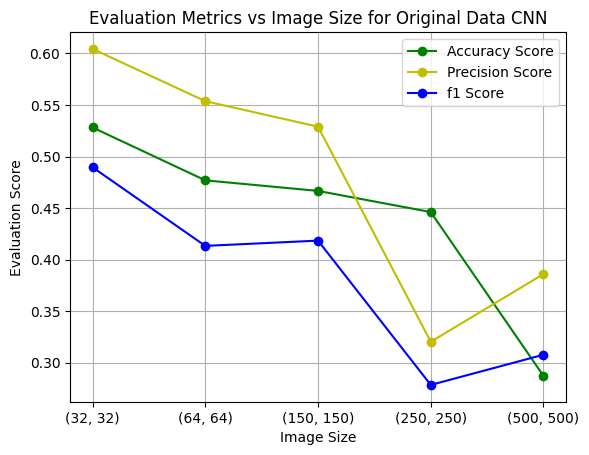

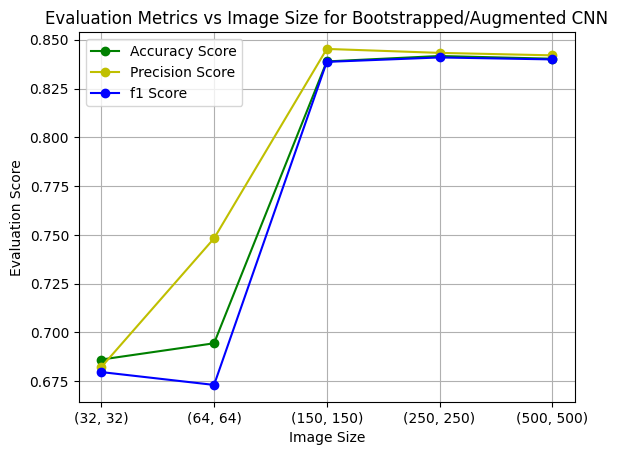

In [13]:
create_accuracy_rating_graph(file_conv_accuracy_results, 'Original Data')

create_accuracy_rating_graph(files_augmented_conv_accuracy_results, 'Bootstrapped/Augmented')

# Creating the ResNet Model
This runs for multiple image sizes to determine the Evaluation Scores based on image size

In [14]:
# List of image sizes
image_size = [ (32, 32), (64, 64), (150, 150), (250, 250), (500, 500)]

# Epoch count, currently set to 5
epochs = 5

# Creating a list to store the image sizes and accuracy ratings for the ResNet model
resNet_accuracy_results = []

def create_resNetModel(image_size, files, Y):
    # Looping through each image size
    for size in image_size:
        # Creating a list of each images numerical values
        X = []

        for file in files:
            img = cv2.imread(file) 
            # Resizing the image based on the specific tuple in image_sizes
            img = cv2.resize(img, (size[0], size[1]))  
            X.append(img)

        # Scaling the image data down to values between 0 and 1
        X = np.array(X, dtype='float32') / 255.0
        
        # Train Test Split to split up the data into training and testing datasets with a current size of 80% training 20% testing data
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=38)

        # Creating a ResNet50V2 model, weights are based off the imagenet dataset and the input shape is set to the image size, currently only doing two layers
        resbase = applications.ResNet50V2(weights = 'imagenet', include_top=False, input_shape= (size[0], size[1], 3))
        # Allows only the new layers to be trainable
        resbase.trainable = False
        # Creating the sequential model utilziing the ResNet model instantiated before and adding more layers to be trained based on the current dataset
        # Currently attempting with only 1 extra layer
        resModel = models.Sequential([
            # Calling the resbase which was assigned to the ResNet model created before
            resbase,

            # Adding our extra layers to be trained
            layers.GlobalAveragePooling2D(),
            layers.Dense(256, activation= 'relu', input_shape = (size[0], size[1], 3)),
            
            # Dense layer of size 3 to match the input size of the numpy array Y
            layers.Dense(3, activation='softmax')
        ])
        
        # Compiling the model utilizing the adam optimizer and categorical crossentropy 
        resModel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        
        # Fitting the model based on the TrainTestSplit data and epochs set from the value epochs
        resModel.fit(X_train, Y_train, epochs = epochs, batch_size=64, validation_split=0.2)

        # Predicting the outputs of the test data using the model
        y_pred = resModel.predict(X_test)
        
        # Converting the One-Hot labels into class indices so they can be used to for evaluation
        Y_test_classes = np.argmax(Y_test, axis=1)
        Y_pred_classes = np.argmax(y_pred, axis = 1)
        
        # Calculating Evaluation Metrics
        accuracy = accuracy_score(Y_test_classes, Y_pred_classes)
        precision = precision_score(Y_test_classes,Y_pred_classes, average='weighted', zero_division=0)
        recall = recall_score(Y_test_classes,Y_pred_classes, average='weighted', zero_division=0)
        f1 = f1_score(Y_test_classes,Y_pred_classes, average='weighted', zero_division=0)
        classification_rep = classification_report(Y_test_classes,Y_pred_classes)

        # Appending all the evaluation metrics into the resNet_accuracy_results list
        resNet_accuracy_results.append((size, accuracy, precision, recall, f1, classification_rep))

        # Printing the Classification Report for that image size
        print(f'Image Size: {size}')
        print(classification_rep)
    return resNet_accuracy_results

In [15]:
file_resnet_accuracy_results = create_resNetModel(image_size=image_size,files=files_labeled,Y=Y)


resNet_accuracy_results = []
files_augmented_resnet_accuracy_results = create_resNetModel(image_size=image_size,files=files_augmented_labeled,Y=Y2)

Epoch 1/5


/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.3773 - loss: 1.0802 - val_accuracy: 0.4423 - val_loss: 1.0935
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.5662 - loss: 0.9178 - val_accuracy: 0.4103 - val_loss: 1.0801
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.6364 - loss: 0.8412 - val_accuracy: 0.4295 - val_loss: 1.0605
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.6614 - loss: 0.8068 - val_accuracy: 0.4423 - val_loss: 1.0544
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.7144 - loss: 0.7598 - val_accuracy: 0.4487 - val_loss: 1.0599
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step
Image Size: (32, 32)
              precision    recall  f1-score   support

           0       0.53      0.62      0.57        88
           1       0.49      0.51      0.50        84
           2       0.33      0.04      0.08        23

    accuracy                           0.51       195
   macro avg       0.45      0.39      0.38    

/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 177ms/step - accuracy: 0.4878 - loss: 1.1878 - val_accuracy: 0.4167 - val_loss: 1.3659
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.7003 - loss: 0.6652 - val_accuracy: 0.4423 - val_loss: 1.4375
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.8601 - loss: 0.4194 - val_accuracy: 0.4551 - val_loss: 1.4673
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.8973 - loss: 0.3201 - val_accuracy: 0.4487 - val_loss: 1.4704
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.9637 - loss: 0.2150 - val_accuracy: 0.4359 - val_loss: 1.5226
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step
Image Size: (64, 64)
              precision    recall  f1-score   support

           0       0.57      0.66      0.61        88
           1       0.53      0.48      0.50        84
           2       0.26      0.22      0.24        23

    accuracy                           0.53       195
   macro avg       0.46      0.45      0.45

/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 449ms/step - accuracy: 0.4112 - loss: 1.8501 - val_accuracy: 0.4615 - val_loss: 1.2672
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 398ms/step - accuracy: 0.5715 - loss: 0.9405 - val_accuracy: 0.5000 - val_loss: 1.0395
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 397ms/step - accuracy: 0.6874 - loss: 0.6924 - val_accuracy: 0.4872 - val_loss: 1.0739
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 402ms/step - accuracy: 0.7560 - loss: 0.5767 - val_accuracy: 0.4936 - val_loss: 1.0964
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 398ms/step - accuracy: 0.8712 - loss: 0.4189 - val_accuracy: 0.4551 - val_loss: 1.1480
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 268ms/step
Image Size: (150, 150)
              precision    recall  f1-score   support

           0       0.54      0.69      0.61        88
           1       0.53      0.48      0.50        84
           2       0.17      0.04      0.07        23

    accuracy                           0.52       195
   macro avg       0.41      0.40      0.

/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.4394 - loss: 1.5627 - val_accuracy: 0.4231 - val_loss: 1.3115
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 956ms/step - accuracy: 0.5543 - loss: 0.9538 - val_accuracy: 0.4872 - val_loss: 1.0085
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 959ms/step - accuracy: 0.6355 - loss: 0.7416 - val_accuracy: 0.5064 - val_loss: 0.9875
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 966ms/step - accuracy: 0.7170 - loss: 0.6623 - val_accuracy: 0.5192 - val_loss: 0.9734
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 971ms/step - accuracy: 0.8002 - loss: 0.5376 - val_accuracy: 0.5192 - val_loss: 1.0222
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 444ms/step
Image Size: (250, 250)
              precision    recall  f1-score   support

           0       0.66      0.52      0.58        88
           1       0.55      0.75      0.63        84
           2       0.50      0.22      0.30        23

    accuracy                           0.58       195
   macro avg       0.57      0.50      0.5

/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.3958 - loss: 1.4577 - val_accuracy: 0.5000 - val_loss: 0.9634
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 37s 4s/step - accuracy: 0.5858 - loss: 0.8476 - val_accuracy: 0.5000 - val_loss: 0.9355
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 37s 4s/step - accuracy: 0.6778 - loss: 0.7587 - val_accuracy: 0.4872 - val_loss: 0.9410
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - accuracy: 0.6891 - loss: 0.7051 - val_accuracy: 0.5128 - val_loss: 0.9628
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - accuracy: 0.7420 - loss: 0.6447 - val_accuracy: 0.5321 - val_loss: 0.9552
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step
Image Size: (500, 500)
              precision    recall  f1-score   support

           0       0.61      0.61      0.61        88
           1       0.53      0.58      0.56        84
           2       0.53      0.35      0.42        23

    accuracy                           0.57       195
   macro avg       0.56      0.51      0.53       195

/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.5283 - loss: 0.9941 - val_accuracy: 0.5938 - val_loss: 0.8698
Epoch 2/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.6539 - loss: 0.8101 - val_accuracy: 0.6753 - val_loss: 0.7802
Epoch 3/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.7346 - loss: 0.6876 - val_accuracy: 0.7014 - val_loss: 0.7182
Epoch 4/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.7820 - loss: 0.5940 - val_accuracy: 0.7326 - val_loss: 0.6697
Epoch 5/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.8048 - loss: 0.5184 - val_accuracy: 0.7674 - val_loss: 0.6314
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step
Image Size: (32, 32)
              precision    recall  f1-score   support

           0       0.65      0.79      0.72       314
           1       0.69      0.68      0.68       300
           2       0.88      0.35      0.50       106

    accuracy                           0.68       720
   macro avg       0.74      0.61      0.63    

/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 0.5377 - loss: 1.1231 - val_accuracy: 0.7257 - val_loss: 0.6617
Epoch 2/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.8280 - loss: 0.4488 - val_accuracy: 0.7934 - val_loss: 0.5002
Epoch 3/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.9369 - loss: 0.2350 - val_accuracy: 0.8316 - val_loss: 0.4915
Epoch 4/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.9832 - loss: 0.1358 - val_accuracy: 0.8438 - val_loss: 0.4788
Epoch 5/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.9919 - loss: 0.0823 - val_accuracy: 0.8455 - val_loss: 0.4700
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step
Image Size: (64, 64)
              precision    recall  f1-score   support

           0       0.84      0.87      0.85       314
           1       0.82      0.84      0.83       300
           2       0.90      0.74      0.81       106

    accuracy                           0.84       720
   macro avg       0.85      0.81      0.8

/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 16s 414ms/step - accuracy: 0.4861 - loss: 1.3669 - val_accuracy: 0.7222 - val_loss: 0.6751
Epoch 2/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 401ms/step - accuracy: 0.7829 - loss: 0.5499 - val_accuracy: 0.7986 - val_loss: 0.4985
Epoch 3/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 403ms/step - accuracy: 0.8937 - loss: 0.3366 - val_accuracy: 0.8854 - val_loss: 0.3880
Epoch 4/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 405ms/step - accuracy: 0.9561 - loss: 0.2039 - val_accuracy: 0.8958 - val_loss: 0.3231
Epoch 5/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 403ms/step - accuracy: 0.9872 - loss: 0.1158 - val_accuracy: 0.8941 - val_loss: 0.3123
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 198ms/step
Image Size: (150, 150)
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       314
           1       0.81      0.87      0.84       300
           2       0.87      0.76      0.81       106

    accuracy                           0.85       720
   macro avg       0.85      0.83 

/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.5066 - loss: 1.2653 - val_accuracy: 0.6719 - val_loss: 0.7535
Epoch 2/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 35s 989ms/step - accuracy: 0.7333 - loss: 0.6343 - val_accuracy: 0.7778 - val_loss: 0.5971
Epoch 3/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 36s 993ms/step - accuracy: 0.8618 - loss: 0.4335 - val_accuracy: 0.7986 - val_loss: 0.5102
Epoch 4/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 36s 995ms/step - accuracy: 0.9231 - loss: 0.2999 - val_accuracy: 0.8559 - val_loss: 0.4014
Epoch 5/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9629 - loss: 0.1946 - val_accuracy: 0.8455 - val_loss: 0.4020
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 433ms/step
Image Size: (250, 250)
              precision    recall  f1-score   support

           0       0.91      0.74      0.82       314
           1       0.73      0.93      0.82       300
           2       0.88      0.69      0.77       106

    accuracy                           0.81       720
   macro avg       0.84      0.79      

/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 144s 4s/step - accuracy: 0.4831 - loss: 1.2321 - val_accuracy: 0.6076 - val_loss: 0.8325
Epoch 2/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - accuracy: 0.6348 - loss: 0.7747 - val_accuracy: 0.6771 - val_loss: 0.7312
Epoch 3/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 141s 4s/step - accuracy: 0.7525 - loss: 0.6173 - val_accuracy: 0.7465 - val_loss: 0.6426
Epoch 4/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 143s 4s/step - accuracy: 0.8068 - loss: 0.5311 - val_accuracy: 0.7951 - val_loss: 0.5662
Epoch 5/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 143s 4s/step - accuracy: 0.8764 - loss: 0.4040 - val_accuracy: 0.7934 - val_loss: 0.5318
23/23 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step
Image Size: (500, 500)
              precision    recall  f1-score   support

           0       0.77      0.96      0.86       314
           1       0.89      0.71      0.79       300
           2       0.80      0.70      0.74       106

    accuracy                           0.82       720
   macro avg       0.82      0.79   

# Graphing the Accuracy Ratings of the ResNet Model

In [16]:
def create_resnet_accuracy_rating_graph(resNet_accuracy_results, title):
    # Creating variables for each item in conv_accuracy_results
    sizes, acc, prec, recall, f1, classrep = zip(*resNet_accuracy_results)

    # Converting the image sizes into a string so they can be used for the X axis
    sizes = [str(size) for size in sizes]

    # Plot showing the Evaluation Metrics compared to Image size
    plt.plot(sizes, acc, marker='o', color = 'g', label = 'Accuracy Score')
    # Not using recall as it is identical to the accuracy rating when tested currently
    #plt.plot(sizes, recall, marker='o', color = 'r', label = 'Recall Score')
    plt.plot(sizes, prec, marker='o', color = 'y', label = 'Precision Score')
    plt.plot(sizes, f1, marker='o', color = 'b', label = 'f1 Score')
    plt.title('Evaluation Metrics vs Image Size for '+title+' ResNet')
    plt.xlabel('Image Size')
    plt.ylabel('Evaluation Score')
    plt.legend()
    plt.grid()
    plt.show()

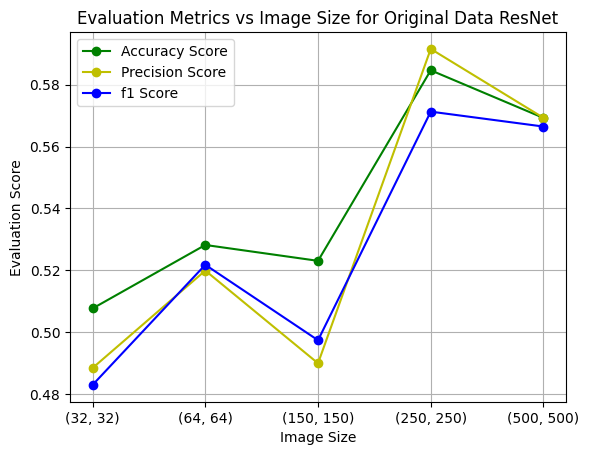

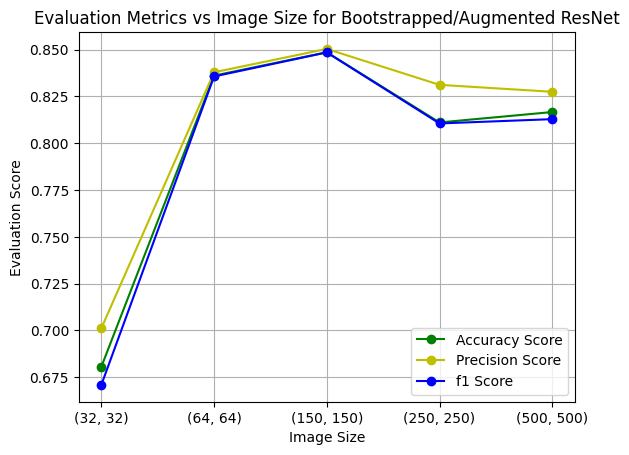

In [17]:
create_resnet_accuracy_rating_graph(file_resnet_accuracy_results, 'Original Data')
create_resnet_accuracy_rating_graph(files_augmented_resnet_accuracy_results, 'Bootstrapped/Augmented')